In [1]:
import os
import sys
import warnings

if bool(os.environ.get("KAGGLE_URL_BASE", "")):
  import sys
  # running on kaggle
  sys.path.insert(0, "/kaggle/input/hsm-source-files")
else:
  # running locally
  sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), "..")))

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from src.utils.utils import get_raw_data_dir, get_processed_data_dir, set_seeds
from src.utils.eeg_spectrogram_creator import EEGSpectrogramGenerator

from tqdm import tqdm

set_seeds(42)

warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)

2025-10-17 10:33:50,167 :: root :: INFO :: Initialising Utils


In [2]:
DATA_PATH = get_raw_data_dir()
print("Data path:", DATA_PATH)

SAVE_PATH = get_processed_data_dir() / "eeg_spectrograms"
TRAIN_SAVE_PATH = SAVE_PATH / "train"

train_df = pd.read_csv(DATA_PATH / "train.csv")
train_eeg_ids = train_df["eeg_id"].unique()

Data path: /home/david/git/aicomp/data


In [3]:
spectrogram_types = ["mel", "stft"]
spectrogram_creator = EEGSpectrogramGenerator(spectrogram_types)

for type in spectrogram_types:
  type_save_path = TRAIN_SAVE_PATH / type
  type_save_path.mkdir(parents=True, exist_ok=True)

We will input it into CNN image model and CNN image model needs the dimensions to be multiples of 32. Then I chose 128x256 (freq x time) because it is close to Kaggle's dimensions of 100x300.

For each eeg_id we will make 1 spectrogram from the middle 50 seconds. We don't want to use more information than 50 seconds at a time because during test inference, we only have access to 50 seconds of EEG for each test eeg_id

Use the following formulas to create the spectrograms for the chains:
- `LL Spec = mean[(spec(Fp1 - F7) + spec(F7 - T3) + spec(T3 - T5) + spec(T5 - O1)]`
- `LP Spec = mean[(spec(Fp1 - F3) + spec(F3 - C3) + spec(C3 - P3) + spec(P3 - O1)]`
- `RR Spec = mean[(spec(Fp2 - F8) + spec(F8 - T4) + spec(T4 - T6) + spec(T6 - O2)]`
- `RP Spec = mean[(spec(Fp2 - F4) + spec(F4 - C4) + spec(C4 - P4) + spec(P4 - O2)]`
- `C Spec = mean[(spec(Fz - Cz) + spec(Cz - Pz)]`

Where `spec(a - b)` is the spectrogram of the difference between electrodes a and b.

In [4]:
def load_middle_50_seconds_of_eeg(data_path, eeg_id):
  eeg = pd.read_parquet(data_path / f"{eeg_id}.parquet")
  middle = (len(eeg) - 10000) // 2 # 10000 samples = 25 seconds
  return eeg.iloc[middle:middle+10_000]

In [5]:
for i, eeg_id in enumerate(tqdm(train_eeg_ids)):
  eeg = load_middle_50_seconds_of_eeg(DATA_PATH / "train_eegs", eeg_id)
  spectrograms = spectrogram_creator.generate(eeg)

  for spectrogram_type, spectrogram in spectrograms.items():
    out_path = TRAIN_SAVE_PATH / spectrogram_type / f"{eeg_id}.npy"
    np.save(out_path, spectrogram)

  0%|          | 15/17089 [00:04<1:18:12,  3.64it/s]


KeyboardInterrupt: 

Example spectrogram shape: (128, 256, 5)
Min value: -0.8333665132522583, Max value: 0.9950249791145325


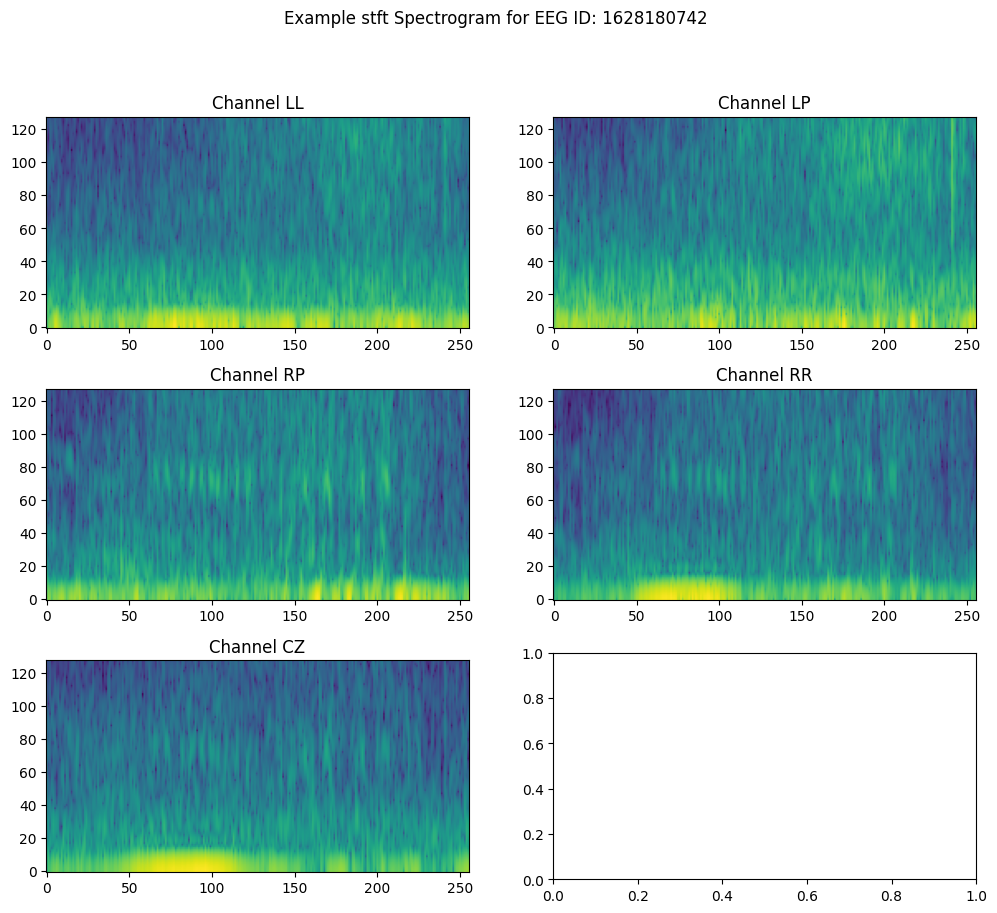

In [8]:
eeg_id = train_eeg_ids[0]
spectrogram_type = "stft"

example_spectrogram_path = TRAIN_SAVE_PATH / spectrogram_type / f"{eeg_id}.npy"
example_spectrogram = np.load(example_spectrogram_path)
print("Example spectrogram shape:", example_spectrogram.shape)
print(f"Min value: {example_spectrogram.min()}, Max value: {example_spectrogram.max()}")

fig, axs = plt.subplots(3, 2, figsize=(12, 10))
fig.suptitle(f"Example {spectrogram_type} Spectrogram for EEG ID: {eeg_id}")
for i in range(len(spectrogram_creator.chain_names)):
    ax = axs.flat[i]
    ax.imshow(example_spectrogram[:, :, i], origin='lower')
    ax.set_title(f'Channel {spectrogram_creator.chain_names[i]}')

Example spectrogram shape: (128, 256, 5)
Min value: -0.8136080503463745, Max value: 0.9950472712516785


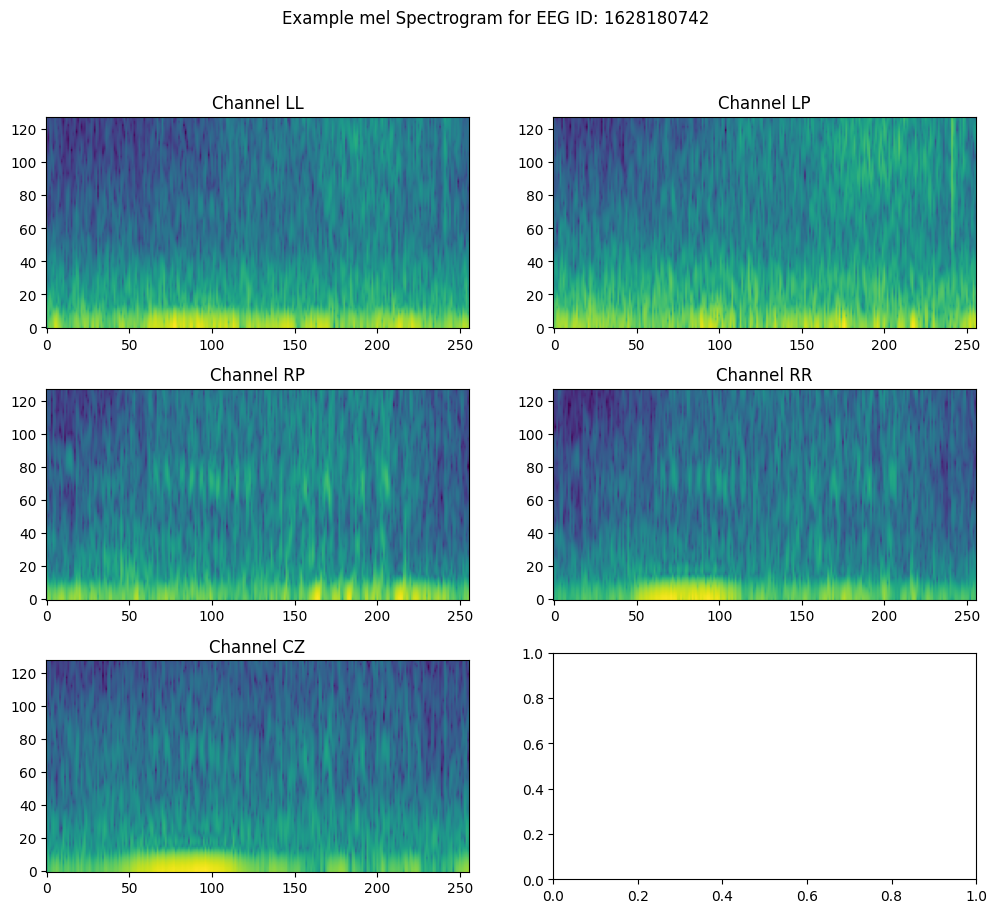

In [9]:
eeg_id = train_eeg_ids[0]
spectrogram_type = "mel"

example_spectrogram_path = TRAIN_SAVE_PATH / spectrogram_type / f"{eeg_id}.npy"
example_spectrogram = np.load(example_spectrogram_path)
print("Example spectrogram shape:", example_spectrogram.shape)
print(f"Min value: {example_spectrogram.min()}, Max value: {example_spectrogram.max()}")

fig, axs = plt.subplots(3, 2, figsize=(12, 10))
fig.suptitle(f"Example {spectrogram_type} Spectrogram for EEG ID: {eeg_id}")
for i in range(len(spectrogram_creator.chain_names)):
    ax = axs.flat[i]
    ax.imshow(example_spectrogram[:, :, i], origin='lower')
    ax.set_title(f'Channel {spectrogram_creator.chain_names[i]}')